# Constructing EOS and solving TOV equations

This example notebook shows how to construct the equation of state with the metamodel and speed-of-sound extension scheme parametrization used in the paper, as well as solve the TOV equations. 

In [1]:
import matplotlib.pyplot as plt
params = {"text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"],
          "xtick.labelsize": 16,
          "ytick.labelsize": 16,
          "axes.labelsize": 16,
          "legend.fontsize": 16,
          "legend.title_fontsize": 16}
plt.rcParams.update(params)

import jax.numpy as jnp

from jesterTOV.eos.metamodel.metamodel_CSE import MetaModel_with_CSE_EOS_model
from jesterTOV.eos.families import construct_family
import jesterTOV.utils as utils

W0120 14:27:36.139021  463485 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0120 14:27:36.142616  463399 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


# Equation of state

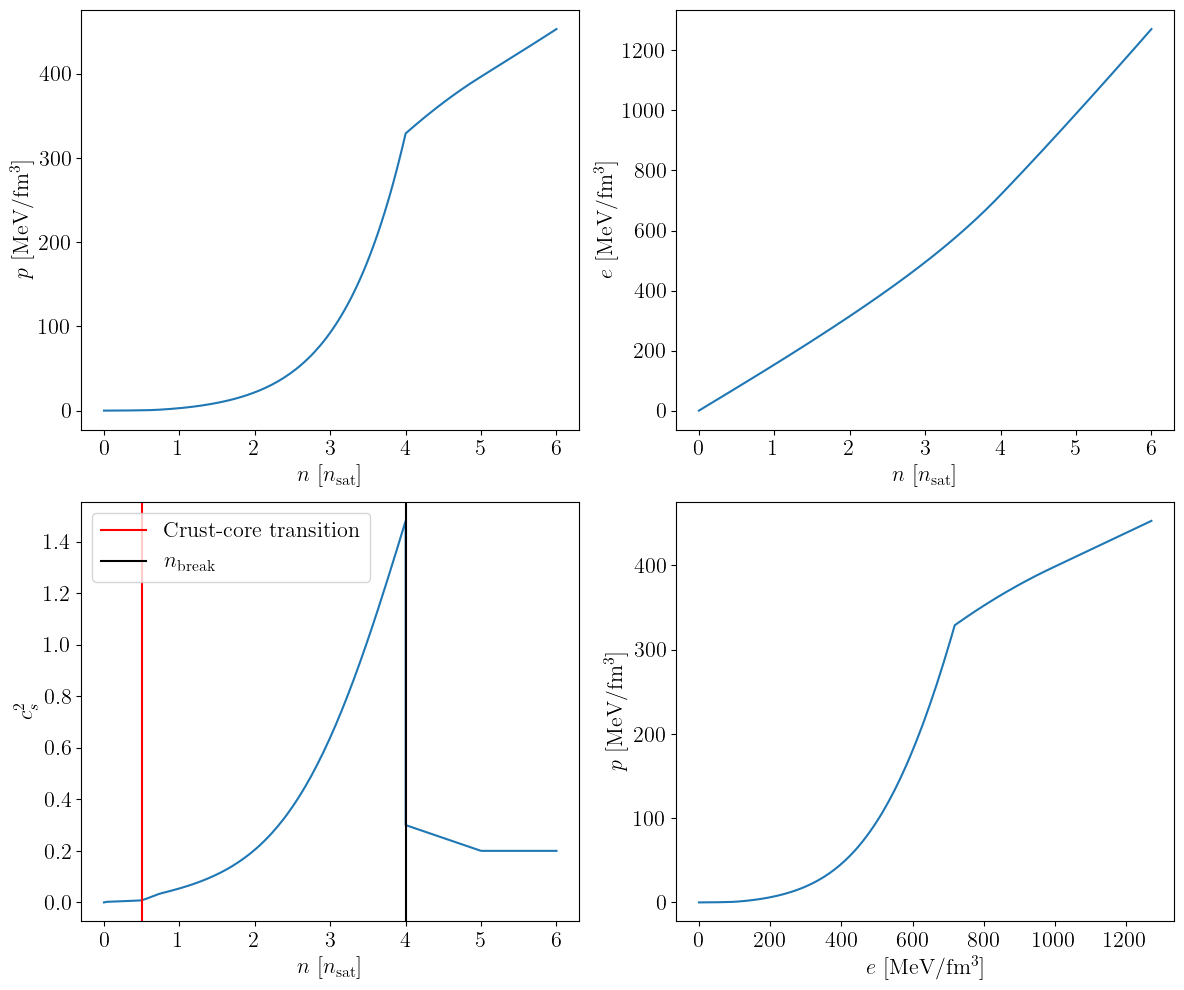

In [2]:
nsat = 0.16 # nuclear saturation density in fm^-3

# Define the EOS object, here we focus on Metamodel with CSE
eos = MetaModel_with_CSE_EOS_model(nmax_nsat=6.0, proton_fraction = 'exact')

# Define the nuclear empirical parameters (NEPs) -- all in MeV
NEP_dict = {"E_sat": -16.0, # saturation parameters
            "K_sat": 200.0,
            "Q_sat": 0.0,
            "Z_sat": 0.0,
            "E_sym": 32.0, # symmetry parameters
            "L_sym": 70.0,
            "K_sym": -100.0,
            "Q_sym": 0.0,
            "Z_sym": 0.0,
            }

# Define the breakdown density -- this is usually between 1-2 nsat
nbreak = 3 * nsat
NEP_dict["nbreak"] = nbreak

# Then we extend with some CSE grid points
ngrids = jnp.array([2.0, 3.0, 4.0, 5.0]) * nsat
cs2grids = jnp.array([0.5, 0.4, 0.3, 0.2]) # speed of sound squared at the grid points

# Now create the EOS -- returns a tuple with most useful EOS quantities
ns, ps, hs, es, dloge_dlogps, mu, cs2 = eos.construct_eos(NEP_dict, ngrids, cs2grids)

# Make a plot
plt.subplots(nrows = 2, ncols = 2, figsize = (12, 10))

# For the plot, let's make some conversions to more common units
ns_plots = ns / utils.fm_inv3_to_geometric / 0.16
es_plots = es / utils.MeV_fm_inv3_to_geometric
ps_plots = ps / utils.MeV_fm_inv3_to_geometric

# p(n)
plt.subplot(221)
plt.plot(ns_plots, ps_plots)
plt.xlabel(r"$n$ [$n_{\rm{sat}}$]")
plt.ylabel(r"$p$ [MeV/fm$^3$]")

# e(n)
plt.subplot(222)
plt.plot(ns_plots, es_plots)
plt.xlabel(r"$n$ [$n_{\rm{sat}}$]")
plt.ylabel(r"$e$ [MeV/fm$^3$]")

# cs2(n)
plt.subplot(223)
plt.plot(ns_plots, cs2)
plt.xlabel(r"$n$ [$n_{\rm{sat}}$]")
plt.ylabel(r"$c_s^2$")
plt.axvline(0.5, color = "red", label = "Crust-core transition")
plt.axvline(nbreak / nsat, color = "black", label = r"$n_{\rm{break}}$")
plt.legend()

# p(e)
plt.subplot(224)
plt.plot(es_plots, ps_plots)
plt.xlabel(r"$e$ [MeV/fm$^3$]")
plt.ylabel(r"$p$ [MeV/fm$^3$]")
plt.tight_layout()
plt.show()
plt.close()

# Neutron stars

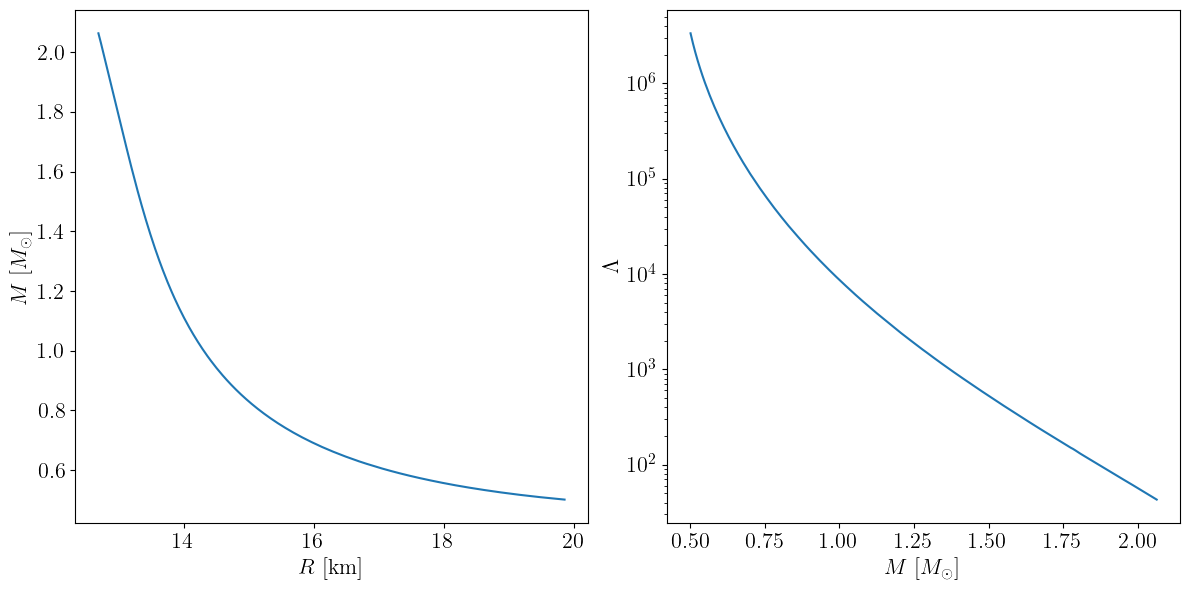

In [3]:
# Solve TOV equations:
eos_tuple = (ns, ps, hs, es, dloge_dlogps, cs2)
logpc, masses, radii, Lambdas = construct_family(eos_tuple, ndat = 200, min_nsat = 1.0)

# Make a plot
plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

# Limit masses to be above certain mass to make plot prettier
m_min = 0.5
mask = masses > m_min
masses = masses[mask]
radii = radii[mask]
Lambdas = Lambdas[mask]

# M(R) plot
plt.subplot(121)
plt.plot(radii, masses)
plt.xlabel(r"$R$ [km]")
plt.ylabel(r"$M$ [$M_\odot$]")

# Lambda(R) plot
plt.subplot(122)
plt.plot(masses, Lambdas)
plt.xlabel(r"$M$ [$M_\odot$]")
plt.ylabel(r"$\Lambda$")
plt.yscale("log")
plt.tight_layout()
plt.show()
plt.close()